# Import Packages

In [1]:
import pandas as pd
from pandas import tseries
import numpy as np
import unicodedata
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC # KJ: force it to be a line
from sklearn.svm import SVC # KJ: and then let it wiggle
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 300

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

## Table: Person

In [2]:
df_person = pd.read_csv('data/2015-traffic-fatalities/person.csv')

In [3]:
df_person.columns

Index(['STATE', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY',
       'DAY', 'MONTH', 'HOUR', 'MINUTE', 'RUR_URB', 'FUNC_SYS', 'HARM_EV',
       'MAN_COLL', 'SCH_BUS', 'MAKE', 'MAK_MOD', 'BODY_TYP', 'MOD_YEAR',
       'TOW_VEH', 'SPEC_USE', 'EMER_USE', 'ROLLOVER', 'IMPACT1', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EJ_PATH', 'EXTRICAT', 'DRINKING', 'ALC_DET',
       'ALC_STATUS', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DRUG_DET', 'DSTATUS',
       'DRUGTST1', 'DRUGTST2', 'DRUGTST3', 'DRUGRES1', 'DRUGRES2', 'DRUGRES3',
       'HOSPITAL', 'DOA', 'DEATH_DA', 'DEATH_MO', 'DEATH_YR', 'DEATH_HR',
       'DEATH_MN', 'DEATH_TM', 'LAG_HRS', 'LAG_MINS', 'P_SF1', 'P_SF2',
       'P_SF3', 'WORK_INJ', 'HISPANIC', 'RACE', 'LOCATION'],
      dtype='object')

In [4]:
df_person = df_person[['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY','HARM_EV', 'MAN_COLL', 
                       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
                       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
                       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS','HOSPITAL', 
                       'DOA'
                      ]]

In [5]:
df_person.sample(5)

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,...,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA
77517,53,530192,1,3,41,8,0,0,14.0,2010.0,...,21,3,0,8,0,0,8,8,0,0
29060,18,180268,1,1,177,12,1,0,66.0,2015.0,...,11,8,0,9,0,9,0,0,0,7
30516,19,190073,1,1,79,8,0,0,66.0,2015.0,...,11,3,0,0,0,0,0,0,0,0
53018,37,370989,2,3,151,12,6,0,20.0,2010.0,...,23,3,0,0,0,0,8,8,5,0
79836,55,550360,1,2,111,12,6,0,14.0,2016.0,...,13,3,0,9,0,0,8,8,1,0


In [6]:
df_person.shape

(80587, 27)

In [7]:
df_person.groupby(['INJ_SEV'])['ST_CASE'].count()

INJ_SEV
0    19704
1     7400
2     9045
3     8324
4    35092
5      250
6        2
9      770
Name: ST_CASE, dtype: int64

**Person Type** (appx - codes changed by year)  
1 Driver (in trans)  
2 Passenger (in trans)  
3 Occupant (not in transport)  
4 Occupant - non motor vehicle  
5 Pedestrian  
6 Bicyclist  
7 Other cyclist  
8 Person on personal conveyance  
9 Unknown occupant type (in trans)  
10 Persons in/on buildings  
19 Unknown type of non-motorist

In [8]:
df_person.groupby(['PER_TYP'])['ST_CASE'].count()
# want to keep drivers (N=48,613) and passengers (N=24,646)

PER_TYP
1     48613
2     24646
3       286
4        66
5      5795
6       851
7         1
8       167
9       131
10       30
19        1
Name: ST_CASE, dtype: int64

In [9]:
# keep drivers and passengers
df_person = df_person[(df_person.PER_TYP == 1) | (df_person.PER_TYP == 2)]

In [10]:
df_person.shape

(73259, 27)

In [11]:
# check values
df_person.groupby(['PER_TYP'])['ST_CASE'].count()

PER_TYP
1    48613
2    24646
Name: ST_CASE, dtype: int64

**Injury Severity**  
0 No apparent injury  
1 Possible injury  
2 Suspected minor injury  
3 Suspected serious injury  
4 Fatal injury  
5 Injured, severity unknown  
6 Died prior to crash  
8 Not reported  
9 Unknown

In [12]:
df_person.groupby(['INJ_SEV'])['ST_CASE'].count()
# Fatalities N=28,597 :(

INJ_SEV
0    19517
1     7283
2     8827
3     8042
4    28597
5      245
6        2
9      746
Name: ST_CASE, dtype: int64

In [13]:
df_person.groupby(['PER_TYP','INJ_SEV'])['ST_CASE'].count()
# Far more driver fatalities than passengers. 
# Will want to check how many people who died were driving alone

PER_TYP  INJ_SEV
1        0          13576
         1           3813
         2           4590
         3           3774
         4          22150
         5            103
         6              2
         9            605
2        0           5941
         1           3470
         2           4237
         3           4268
         4           6447
         5            142
         9            141
Name: ST_CASE, dtype: int64

In [14]:
df_person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 80586
Data columns (total 27 columns):
STATE       73259 non-null int64
ST_CASE     73259 non-null int64
VEH_NO      73259 non-null int64
PER_NO      73259 non-null int64
COUNTY      73259 non-null int64
HARM_EV     73259 non-null int64
MAN_COLL    73259 non-null int64
SCH_BUS     73259 non-null int64
BODY_TYP    73259 non-null float64
MOD_YEAR    73259 non-null float64
TOW_VEH     73259 non-null float64
ROLLOVER    73259 non-null float64
FIRE_EXP    73259 non-null float64
AGE         73259 non-null int64
SEX         73259 non-null int64
PER_TYP     73259 non-null int64
INJ_SEV     73259 non-null int64
SEAT_POS    73259 non-null int64
REST_USE    73259 non-null int64
REST_MIS    73259 non-null int64
AIR_BAG     73259 non-null int64
EJECTION    73259 non-null int64
EXTRICAT    73259 non-null int64
DRINKING    73259 non-null int64
DRUGS       73259 non-null int64
HOSPITAL    73259 non-null int64
DOA         73259 non-n

In [15]:
# change data types of floats to int
df_person[['BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP']] = df_person[[
    'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP']].astype(int)

## Table: Accident

In [16]:
df_accident = pd.read_csv('data/2015-traffic-fatalities/accident.csv')

In [17]:
df_person.columns # what we already have

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA'],
      dtype='object')

In [18]:
df_accident.columns # want to pull some of these

Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERNOTMVIT', 'PERMVIT', 'PERSONS', 'COUNTY', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'NHS', 'RUR_URB', 'FUNC_SYS',
       'RD_OWNER', 'ROUTE', 'TWAY_ID', 'TWAY_ID2', 'MILEPT', 'LATITUDE',
       'LONGITUD', 'SP_JUR', 'HARM_EV', 'MAN_COLL', 'RELJCT1', 'RELJCT2',
       'TYP_INT', 'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'SCH_BUS', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR',
       'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'CF1', 'CF2', 'CF3', 'FATALS',
       'DRUNK_DR'],
      dtype='object')

In [19]:
df_accident = df_accident[['ST_CASE', 'STATE', 'SCH_BUS', 'PEDS', 'CITY', 'DAY', 'MONTH', 'YEAR', 'DAY_WEEK', 
                           'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD', 'LGT_COND', 'WEATHER1', 
                           'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 
                           'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR']]

In [20]:
df_accident.shape # has 26 columns and over 32K observations

(32166, 26)

In [21]:
df_accident.sample(5)

,ST_CASE,STATE,SCH_BUS,PEDS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,...,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR
5423,80378,8,0,1,600,29,9,2015,3,13,...,1,13,54,13,55,16,0,0,1,0
2574,60452,6,0,0,1560,13,3,2015,6,21,...,1,99,99,99,99,14,0,0,2,1
3053,60931,6,0,0,560,10,5,2015,1,5,...,1,99,99,99,99,0,0,0,1,0
13826,220622,22,0,0,0,12,12,2015,7,19,...,10,19,11,19,18,0,0,0,1,1
9459,130813,13,0,1,400,23,8,2015,1,3,...,1,99,98,99,98,0,0,0,1,0


In [22]:
df_accident['WEATHER1'].describe

<bound method NDFrame.describe of 0         1
1        10
2         1
3        10
4         1
5         1
6         1
7         2
8        10
9         1
10        1
11        1
12        1
13       10
14        1
15       10
16       10
17        1
18        1
19        2
20        2
21        1
22        5
23        1
24        1
25       10
26        1
27        1
28        2
29        1
         ..
32136     1
32137     1
32138     1
32139    10
32140     1
32141     1
32142     1
32143     1
32144    10
32145     1
32146     1
32147     1
32148     2
32149    99
32150     1
32151    10
32152     1
32153     1
32154     1
32155     1
32156     1
32157     1
32158     1
32159     1
32160     1
32161     1
32162     1
32163     1
32164     4
32165     1
Name: WEATHER1, Length: 32166, dtype: int64>

In [23]:
df_accident['WEATHER1'].isnull().sum().sum() # weather has no nulls in accident file

0

## Table: Vehicle

In [24]:
df_vehicle = pd.read_csv('data/2015-traffic-fatalities/vehicle.csv', encoding='ISO-8859-1')
# Not sure why encoding was different on this file

In [25]:
df_vehicle.head()

,STATE,ST_CASE,VEH_NO,VE_FORMS,NUMOCCS,DAY,MONTH,HOUR,MINUTE,HARM_EV,...,VTRAFCON,VTCONT_F,P_CRASH1,P_CRASH2,P_CRASH3,PCRASH4,PCRASH5,ACC_TYPE,DEATHS,DR_DRINK
0,1,10001,1,1,1,1,1,2,40,35,...,0,0,14,13,99,1,4,1,1,1
1,1,10002,1,1,1,1,1,22,13,34,...,0,0,14,6,1,4,4,7,1,0
2,1,10003,1,1,2,1,1,1,25,42,...,0,0,1,13,1,1,4,1,1,1
3,1,10004,1,1,1,4,1,0,57,53,...,0,0,14,13,1,1,4,1,1,1
4,1,10005,1,2,1,7,1,7,9,12,...,0,0,11,15,1,1,1,68,1,0


In [26]:
pd.set_option('display.max_columns', 150)
pd.get_option('display.max_columns')

150

In [27]:
df_vehicle.columns.values
# had to call values because it used ... for middle

array(['STATE', 'ST_CASE', 'VEH_NO', 'VE_FORMS', 'NUMOCCS', 'DAY',
       'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'UNITTYPE',
       'HIT_RUN', 'REG_STAT', 'OWNER', 'MAKE', 'MODEL', 'MAK_MOD',
       'BODY_TYP', 'MOD_YEAR', 'VIN', 'VIN_1', 'VIN_2', 'VIN_3', 'VIN_4',
       'VIN_5', 'VIN_6', 'VIN_7', 'VIN_8', 'VIN_9', 'VIN_10', 'VIN_11',
       'VIN_12', 'TOW_VEH', 'J_KNIFE', 'MCARR_I1', 'MCARR_I2', 'MCARR_ID',
       'GVWR', 'V_CONFIG', 'CARGO_BT', 'HAZ_INV', 'HAZ_PLAC', 'HAZ_ID',
       'HAZ_CNO', 'HAZ_REL', 'BUS_USE', 'SPEC_USE', 'EMER_USE', 'TRAV_SP',
       'UNDERIDE', 'ROLLOVER', 'ROLINLOC', 'IMPACT1', 'DEFORMED', 'TOWED',
       'M_HARM', 'VEH_SC1', 'VEH_SC2', 'FIRE_EXP', 'DR_PRES', 'L_STATE',
       'DR_ZIP', 'L_STATUS', 'L_TYPE', 'CDL_STAT', 'L_ENDORS', 'L_COMPL',
       'L_RESTRI', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS', 'PREV_DWI',
       'PREV_SPD', 'PREV_OTH', 'FIRST_MO', 'FIRST_YR', 'LAST_MO',
       'LAST_YR', 'SPEEDREL', 'DR_SF1', 'DR_SF2', 'DR_SF3', 'DR_SF

In [28]:
df_vehicle = df_vehicle[['ST_CASE', 'STATE', 'MAN_COLL', 'VEH_NO', 'NUMOCCS', 'HIT_RUN', 
                         'REG_STAT', 'VIN', 'J_KNIFE', 'GVWR', 'HAZ_INV', 'BUS_USE', 
                         'TRAV_SP', 'UNDERIDE', 'IMPACT1', 'DEFORMED', 'TOWED','M_HARM', 
                         'VEH_SC1', 'VEH_SC2', 'L_STATE', 'DEATHS', 'DR_DRINK', 'DR_ZIP', 
                         'L_STATUS', 'L_TYPE', 'L_ENDORS', 'L_COMPL', 'DR_HGT', 'DR_WGT', 
                         'PREV_ACC', 'PREV_SUS', 'PREV_DWI', 'PREV_SPD', 'PREV_OTH', 
                         'SPEEDREL', 'DR_SF1', 'DR_SF2', 'DR_SF3', 'DR_SF4', 'VNUM_LAN', 
                         'VSPD_LIM', 'VPROFILE','VSURCOND'
                        ]]

In [29]:
df_vehicle.sample(5)

,ST_CASE,STATE,MAN_COLL,VEH_NO,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
9118,120048,12,6,2,1,0,12,1FTJX35K8RKB,0,0,1,0,998,0,11,6,2,12,0,0,12,0,0,34772,6,1,0,3,72,999,1,14,0,2,3,0,0,0,0,0,4,50,1,2
37431,440025,44,2,2,1,0,44,1FMCU02Z48KD,0,0,1,0,999,0,12,6,2,12,0,0,44,1,1,2904,6,1,0,3,71,170,0,0,0,0,1,0,51,0,0,0,4,55,5,1
19306,210144,21,0,1,1,0,21,1GCDT19X1V81,0,0,1,0,998,0,12,6,2,30,0,0,21,1,0,42743,6,1,0,3,69,200,1,0,0,0,0,0,87,0,0,0,2,55,2,4
16255,170426,17,6,1,1,0,94,1GBCS10A7P29,0,0,1,0,998,0,9,6,2,12,0,0,17,0,0,62249,6,1,0,3,61,110,0,0,0,0,0,5,38,0,0,0,2,45,1,1
45612,490209,49,0,1,2,0,32,2CNBE6340169,0,0,1,0,999,0,0,6,2,1,0,0,6,2,1,95501,1,1,0,2,76,200,0,1,1,0,0,0,58,0,0,0,2,80,1,2


In [30]:
df_vehicle.shape # has 44 columns and almost 49K observations

(48923, 44)

# Merge and Clean Data

## Merge DataFrames

**Create Master DataFrame**  
Use `df_person` as starting point

In [31]:
df_master = df_person.copy()
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7


In [32]:
df_master.shape # checking shape - this is correct

(73259, 27)

**Add Accident**  
Merge `accident.csv` data (`df_accident`) onto `person.csv` data (`df_master`) using `ST_CASE` to merge. Note that `STATE` and `SCH_BUS` are duplicate columns and should be appended with `_ACC`.

In [33]:
df_master = df_master.merge(df_accident, on='ST_CASE', how='left', suffixes=('', '_ACC'), validate='many_to_one')

# FIRST ATTEMPT: Mostly NaNs
# df_master = df_master.join(df_accident, on='ST_CASE', how='left', rsuffix='_ACCjoin')

In [34]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'PEDS', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD',
       'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN',
       'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR'],
      dtype='object')

In [35]:
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7,1,0,0,0,1,1,2015,5,2,40,33.878653,-87.325328,2,1,0,1,99,99,2,58,0,0,0,1,1
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7,1,0,0,0,1,1,2015,5,22,13,34.910442,-86.908708,2,10,0,10,99,99,22,20,0,0,0,1,0
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7,1,0,0,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0,1,0,0,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7,1,0,0,0,4,1,2015,1,0,57,31.439814,-85.510300,2,10,0,10,99,99,1,15,0,0,0,1,1


In [36]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Data columns (total 52 columns):
STATE          73259 non-null int64
ST_CASE        73259 non-null int64
VEH_NO         73259 non-null int64
PER_NO         73259 non-null int64
COUNTY         73259 non-null int64
HARM_EV        73259 non-null int64
MAN_COLL       73259 non-null int64
SCH_BUS        73259 non-null int64
BODY_TYP       73259 non-null int64
MOD_YEAR       73259 non-null int64
TOW_VEH        73259 non-null int64
ROLLOVER       73259 non-null int64
FIRE_EXP       73259 non-null int64
AGE            73259 non-null int64
SEX            73259 non-null int64
PER_TYP        73259 non-null int64
INJ_SEV        73259 non-null int64
SEAT_POS       73259 non-null int64
REST_USE       73259 non-null int64
REST_MIS       73259 non-null int64
AIR_BAG        73259 non-null int64
EJECTION       73259 non-null int64
EXTRICAT       73259 non-null int64
DRINKING       73259 non-null int64
DRUGS          73259 non-nu

In [37]:
# head has values
df_master[['ST_CASE', 'STATE','STATE_ACC','SCH_BUS','SCH_BUS_ACC', 'WEATHER1', 'LATITUDE']].head(10)

,ST_CASE,STATE,STATE_ACC,SCH_BUS,SCH_BUS_ACC,WEATHER1,LATITUDE
0,10001,1,1,0,0,1,33.878653
1,10002,1,1,0,0,10,34.910442
2,10003,1,1,0,0,1,32.142006
3,10003,1,1,0,0,1,32.142006
4,10004,1,1,0,0,10,31.439814
5,10005,1,1,0,0,1,31.319331
6,10005,1,1,0,0,1,31.319331
7,10006,1,1,0,0,1,33.438494
8,10006,1,1,0,0,1,33.438494
9,10007,1,1,0,0,1,34.773044


In [38]:
# tail has values!! No longer all NaNs
df_master[['ST_CASE', 'STATE','STATE_ACC','SCH_BUS','SCH_BUS_ACC', 'WEATHER1', 'LATITUDE']].tail(10)

,ST_CASE,STATE,STATE_ACC,SCH_BUS,SCH_BUS_ACC,WEATHER1,LATITUDE
73249,560127,56,56,0,0,1,41.056478
73250,560127,56,56,0,0,1,41.056478
73251,560127,56,56,0,0,1,41.056478
73252,560128,56,56,0,0,1,41.159400
73253,560128,56,56,0,0,1,41.159400
73254,560129,56,56,0,0,4,41.531100
73255,560129,56,56,0,0,4,41.531100
73256,560129,56,56,0,0,4,41.531100
73257,560129,56,56,0,0,4,41.531100
73258,560130,56,56,0,0,1,44.823689


In [39]:
df_master['WEATHER1'].isnull().values.any() # also good news!

False

**Add Vehicle**  
Merge `vehicle.csv` data (df_vehicle) onto `person.csv` data (df_master) using `ST_CASE` and `VEH_NO` to merge. Check success with `STATE_TEST_ACC` and `SCH_BUS_TEST_ACC`.

In [40]:
df_master = df_master.merge(df_vehicle, on=['ST_CASE','VEH_NO'], how='left', suffixes=('', '_VEH'), 
                            validate='many_to_one')

In [41]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'PEDS', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD',
       'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN',
       'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR',
       'STATE_VEH', 'MAN_COLL_VEH', 'NUMOCCS', 'HIT_RUN', 'REG_STAT', 'VIN',
       'J_KNIFE', 'GVWR', 'HAZ_INV', 'BUS_USE', 'TRAV_SP', 'UNDERIDE',
       'IMPACT1', 'DEFORMED', 'TOWED', 'M_HARM', 'VEH_SC1', 'VEH_SC2',
       'L_STATE', 'DEATHS', 'DR_DRINK', 'DR_ZIP', 'L_STATUS', 'L_TYPE',
       'L_ENDORS', 'L_COMPL', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS',
       'PREV_DWI', 'PREV_SPD', 

In [42]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Data columns (total 94 columns):
STATE           73259 non-null int64
ST_CASE         73259 non-null int64
VEH_NO          73259 non-null int64
PER_NO          73259 non-null int64
COUNTY          73259 non-null int64
HARM_EV         73259 non-null int64
MAN_COLL        73259 non-null int64
SCH_BUS         73259 non-null int64
BODY_TYP        73259 non-null int64
MOD_YEAR        73259 non-null int64
TOW_VEH         73259 non-null int64
ROLLOVER        73259 non-null int64
FIRE_EXP        73259 non-null int64
AGE             73259 non-null int64
SEX             73259 non-null int64
PER_TYP         73259 non-null int64
INJ_SEV         73259 non-null int64
SEAT_POS        73259 non-null int64
REST_USE        73259 non-null int64
REST_MIS        73259 non-null int64
AIR_BAG         73259 non-null int64
EJECTION        73259 non-null int64
EXTRICAT        73259 non-null int64
DRINKING        73259 non-null int64
DRU

In [43]:
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7,1,0,0,0,1,1,2015,5,2,40,33.878653,-87.325328,2,1,0,1,99,99,2,58,0,0,0,1,1,1,0,1,0,1,1FTRX18L83NB,0,0,1,0,55,0,12,6,2,42,0,0,1,1,1,35578,6,1,0,3,73,205,1,0,0,1,0,0,0,0,0,0,2,55,1,1
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7,1,0,0,0,1,1,2015,5,22,13,34.910442,-86.908708,2,10,0,10,99,99,22,20,0,0,0,1,0,1,0,1,0,1,4T1BE30K66U1,0,0,1,0,70,0,6,6,2,1,0,0,1,1,0,60565,6,1,0,3,70,190,2,2,0,0,0,4,89,0,0,0,2,70,1,2
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7,1,0,0,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1,1,0,2,0,1,1G1ZK57728F1,0,0,1,0,80,0,12,6,2,42,0,0,1,1,1,36089,6,1,0,3,68,157,2,0,0,1,0,0,0,0,0,0,2,55,1,1
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0,1,0,0,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1,1,0,2,0,1,1G1ZK57728F1,0,0,1,0,80,0,12,6,2,42,0,0,1,1,1,36089,6,1,0,3,68,157,2,0,0,1,0,0,0,0,0,0,2,55,1,1
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7,1,0,0,0,4,1,2015,1,0,57,31.439814,-85.510300,2,10,0,10,99,99,1,15,0,0,0,1,1,1,0,1,0,12,1FTRF12245KE,0,0,1,0,75,0,12,6,2,42,0,0,12,1,1,36360,6,1,0,3,72,999,0,0,0,0,0,0,0,0,0,0,2,55,1,1


In [44]:
df_master.tail()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
73254,56,560129,1,1,21,12,6,0,15,1996,0,0,0,26,1,1,4,11,3,0,20,0,0,0,1,0,7,56,0,0,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73255,56,560129,1,2,21,12,6,0,15,1996,0,0,0,27,2,2,2,23,7,0,0,0,0,8,8,5,0,56,0,0,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73256,56,560129,1,3,21,12,6,0,15,1996,0,0,0,0,1,2,3,23,7,0,0,0,0,8,8,5,0,56,0,0,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73257,56,560129,2,1,21,12,6,0,66,2011,2,0,0,30,1,1,0,11,3,0,0,0,0,0,0,0,0,56,0,0,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,1,0,31,1FVXFB001BDA,1,3,1,0,65,0,7,6,2,12,0,0,96,0,0,69361,9,1,3,9,999,999,99,99,99,99,99,0,0,0,0,0,2,65,1,2
73258,56,560130,1,1,33,1,0,0,66,2006,1,1,0,28,1,1,4,11,3,0,0,0,1,0,0,5,0,56,0,0,0,19,12,2015,7,21,55,44.823689,-107.328131,2,1,0,1,21,59,22,25,0,0,0,1,0,56,0,1,0,93,1FUJBBCK66LW,1,3,1,0,999,0,0,6,2,1,0,0,4,1,0,85023,6,1,0,3,74,196,0,0,0,1,1,4,0,0,0,0,2,40,6,1


In [45]:
df_master.shape

(73259, 94)

## Clean Data

### Drop Nulls

In [46]:
# only 5 nulls, all in VIN
column_list = list(df_master.columns)
null_list = list(df_master.isnull().sum())
for a,b in list(zip(column_list, null_list)):
    if b > 0:
        print(a,b)

VIN 5


In [47]:
# ...so drop VIN because it's not useful for classification
# now expect 93 columns
df_master = df_master.drop('VIN', axis=1)
df_master.shape

(73259, 93)

### Add Unique Identifier

In [48]:
# make identifiers strings
df_master[['ST_CASE', 'VEH_NO', 'PER_NO']] = df_master[['ST_CASE', 'VEH_NO', 'PER_NO']].astype(str)

In [49]:
df_master['UNIQ_ID'] = df_master['ST_CASE'] + '_' + df_master['VEH_NO'] + '_' + df_master['PER_NO']

In [50]:
df_master['UNIQ_ID'].sample(20)

16140    121155_1_1
26200    180360_1_5
69509    510462_3_1
25183    170858_1_1
53798    420213_2_1
13220     90232_2_3
65571    482225_1_2
21096    130582_1_1
37005    280226_1_2
1342      10592_2_2
30517    220187_1_1
55151    420798_2_4
31497    220649_1_2
66217    482512_1_1
44482    360559_1_1
70690    530337_1_1
38091    290129_1_1
34750    260561_3_1
13304    100011_3_1
55874    440027_1_1
Name: UNIQ_ID, dtype: object

### Create Target
Need to turn `INJ_SEV` = 4 into binary `FATALITY_TARG` variable

**Injury Severity**  
0 No apparent injury  
1 Possible injury  
2 Suspected minor injury  
3 Suspected serious injury  
**4 Fatal injury**  
5 Injured, severity unknown  
6 Died prior to crash  
8 Not reported  
9 Unknown

In [51]:
df_INJ_SEV = pd.get_dummies(df_master['INJ_SEV'], prefix="INJ_SEV")

In [52]:
df_INJ_SEV.head()

,INJ_SEV_0,INJ_SEV_1,INJ_SEV_2,INJ_SEV_3,INJ_SEV_4,INJ_SEV_5,INJ_SEV_6,INJ_SEV_9
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [53]:
df_master = pd.concat([df_master, df_INJ_SEV], axis=1)

In [54]:
df_master.sample(5)

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,UNIQ_ID,INJ_SEV_0,INJ_SEV_1,INJ_SEV_2,INJ_SEV_3,INJ_SEV_4,INJ_SEV_5,INJ_SEV_6,INJ_SEV_9
71447,54,540105,1,1,61,11,0,0,15,2003,0,1,0,27,1,1,4,11,7,0,20,1,0,9,9,0,7,54,0,0,1840,25,6,2015,5,2,0,39.717625,-80.061161,2,1,0,1,2,4,2,10,0,0,0,1,0,54,0,1,0,54,0,0,1,0,998,0,12,6,2,1,0,0,54,1,0,26301,6,1,0,3,68,132,0,3,0,0,4,0,83,0,0,0,2,70,1,1,540105_1_1,0,0,0,0,1,0,0,0
55825,44,440009,2,1,7,42,7,0,20,2000,0,0,0,27,2,1,0,11,3,0,20,0,0,0,0,0,0,44,0,0,190,17,4,2015,6,23,4,41.807292,-71.440519,3,1,0,1,23,8,23,12,0,0,0,1,1,44,7,6,0,44,0,0,1,0,999,0,8,6,5,12,0,0,44,0,0,2909,6,1,0,3,62,130,1,0,0,0,0,0,0,0,0,0,1,25,5,1,440009_2_1,1,0,0,0,0,0,0,0
36210,27,270249,1,1,115,23,0,0,3,1991,0,1,0,29,1,1,4,11,7,0,0,1,0,9,9,0,7,27,0,0,0,13,9,2015,1,3,36,45.985603,-92.948069,2,1,0,1,3,19,3,26,0,0,0,1,1,27,0,1,0,27,0,0,1,0,998,0,12,6,2,1,0,0,27,1,1,55079,6,1,0,3,70,175,2,1,0,0,0,0,0,0,0,0,2,70,2,1,270249_1_1,0,0,0,0,1,0,0,0
42819,35,350080,1,2,7,1,0,0,14,2002,0,9,0,34,1,2,4,13,7,0,1,1,0,8,8,0,7,35,0,0,0,3,5,2015,1,9,51,36.449264,-104.716625,1,1,0,1,9,45,10,6,0,0,0,1,1,35,0,4,0,35,0,0,1,0,998,0,0,6,2,1,0,0,35,1,1,87714,0,0,0,0,999,999,99,99,99,99,99,0,6,0,0,0,2,55,1,1,350080_1_2,0,0,0,0,1,0,0,0
67085,48,482874,2,4,227,12,1,0,14,2012,0,0,0,3,1,2,0,23,10,0,20,0,0,8,8,0,0,48,0,0,640,1,12,2015,3,18,21,32.237983,-101.472914,3,1,0,1,18,24,18,26,0,0,0,1,0,48,1,7,0,48,0,0,1,0,0,0,6,2,3,12,0,0,48,0,0,79720,6,1,0,3,999,999,1,0,0,1,0,0,0,0,0,0,5,40,1,1,482874_2_4,1,0,0,0,0,0,0,0


In [55]:
df_master['FATALITY_TARGET'] = df_master['INJ_SEV_4']

In [56]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR',
       ...
       'UNIQ_ID', 'INJ_SEV_0', 'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3',
       'INJ_SEV_4', 'INJ_SEV_5', 'INJ_SEV_6', 'INJ_SEV_9', 'FATALITY_TARGET'],
      dtype='object', length=103)

In [57]:
# will drop these later
# df_master.drop(columns=['INJ_SEV_0', 'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3', 'INJ_SEV_4', 'INJ_SEV_5', 'INJ_SEV_6', 'INJ_SEV_9'])

### Change Floats to Ints (as needed)

In [58]:
# says that most everything is an int
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Columns: 103 entries, STATE to FATALITY_TARGET
dtypes: float64(2), int64(88), object(4), uint8(9)
memory usage: 53.7+ MB


### Fix Time

In [59]:
df_master['DATE'] = pd.to_datetime(df_master[['DAY', 'MONTH', 'YEAR']])
df_master['DATE_TIME'] = pd.to_datetime(df_master[['DAY', 'MONTH', 'YEAR', 'HOUR', 'MINUTE']])
df_master[['DATE', 'DATE_TIME', 'DAY_WEEK']].sample(10)

,DATE,DATE_TIME,DAY_WEEK
55829,2015-04-17,2015-04-17 23:04:00,6
35071,2015-10-21,2015-10-21 07:30:00,4
22705,2015-12-21,2015-12-21 04:14:00,2
7205,2015-05-25,2015-05-25 22:10:00,2
821,2015-06-30,2015-06-30 06:04:00,3
45210,2015-11-29,2015-11-29 17:03:00,1
12769,2015-02-21,2015-02-21 01:54:00,7
13664,2015-01-05,2015-01-05 21:55:00,2
107,2015-02-03,2015-02-03 17:30:00,3
36698,2015-02-28,2015-02-28 20:00:00,7


# Exploratory Data Analysis

## Date and Time

In [60]:
# most common date for crashes is Valentine's Day. What??
df_master['DATE'].describe()

count                   73259
unique                    365
top       2015-02-14 00:00:00
freq                      379
first     2015-01-01 00:00:00
last      2015-12-31 00:00:00
Name: DATE, dtype: object

In [61]:
# some dates run into early Jan 2016
df_master['DATE_TIME'].describe()

count                   73259
unique                  30606
top       2015-09-24 11:11:00
freq                       93
first     2015-01-01 00:15:00
last      2016-01-04 04:39:00
Name: DATE_TIME, dtype: object

In [62]:
df_master.groupby(['HOUR'])['ST_CASE'].count()
#df_master['HOUR'].describe()

HOUR
0     2469
1     2361
2     2340
3     1767
4     1445
5     1975
6     2464
7     2562
8     2111
9     2331
10    2424
11    2841
12    3182
13    3446
14    3867
15    4366
16    4220
17    4461
18    4414
19    4084
20    4001
21    3951
22    3198
23    2667
99     312
Name: ST_CASE, dtype: int64

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


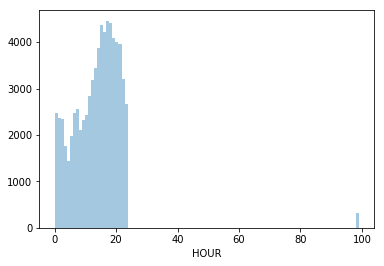

In [63]:
sns.distplot(df_master['HOUR'], kde=False, bins=100)

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


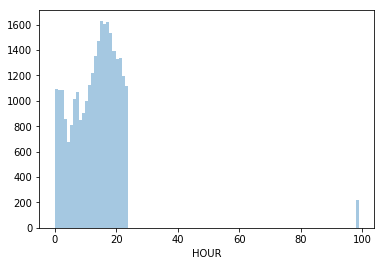

In [64]:
# Fatalities only
df_fatal = df_master[(df_master.INJ_SEV == 4)]
sns.distplot(df_fatal['HOUR'], kde=False, bins=100)

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


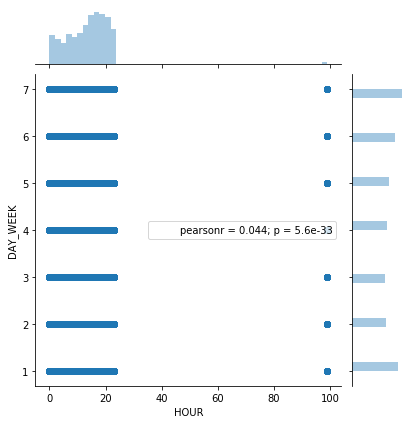

In [65]:
sns.jointplot(x='HOUR', y='DAY_WEEK', data=df_master)

In [66]:
df_master.groupby(['DAY_WEEK'])['ST_CASE'].count()
# way more incidents on Friday (6), Saturday (7), and Sunday (1)

DAY_WEEK
1    12021
2     8828
3     8776
4     9241
5     9860
6    11359
7    13174
Name: ST_CASE, dtype: int64

In [67]:
# want fatality count by day but only have person count
df_master.groupby(['DATE'])['ST_CASE'].count()

# This doesn't work:
# df_master['INJ_SEV' == 4].groupby(['DATE'])['ST_CASE'].count()

DATE
2015-01-01    207
2015-01-02    159
2015-01-03    211
2015-01-04    131
2015-01-05    190
2015-01-06    185
2015-01-07    141
2015-01-08    133
2015-01-09    357
2015-01-10    166
2015-01-11    157
2015-01-12    128
2015-01-13    174
2015-01-14    161
2015-01-15    133
2015-01-16    157
2015-01-17    163
2015-01-18    254
2015-01-19    134
2015-01-20    152
2015-01-21    140
2015-01-22    126
2015-01-23    193
2015-01-24    218
2015-01-25    178
2015-01-26    127
2015-01-27    130
2015-01-28    122
2015-01-29    124
2015-01-30    194
             ... 
2015-12-02    192
2015-12-03    231
2015-12-04    211
2015-12-05    254
2015-12-06    265
2015-12-07    158
2015-12-08    172
2015-12-09    160
2015-12-10    168
2015-12-11    240
2015-12-12    239
2015-12-13    248
2015-12-14    215
2015-12-15    186
2015-12-16    164
2015-12-17    201
2015-12-18    183
2015-12-19    264
2015-12-20    181
2015-12-21    166
2015-12-22    212
2015-12-23    312
2015-12-24    205
2015-12-25    224
2015-

# Classification Models

## Create DataFrame for Modeling

### DataFrame 1 - Drop Some Columns

In [68]:
df_master.columns.values

array(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV',
       'MAN_COLL', 'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH',
       'ROLLOVER', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP', 'INJ_SEV',
       'SEAT_POS', 'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION',
       'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL', 'DOA', 'STATE_ACC',
       'SCH_BUS_ACC', 'PEDS', 'CITY', 'DAY', 'MONTH', 'YEAR', 'DAY_WEEK',
       'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD', 'LGT_COND', 'WEATHER1',
       'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR',
       'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR', 'STATE_VEH',
       'MAN_COLL_VEH', 'NUMOCCS', 'HIT_RUN', 'REG_STAT', 'J_KNIFE',
       'GVWR', 'HAZ_INV', 'BUS_USE', 'TRAV_SP', 'UNDERIDE', 'IMPACT1',
       'DEFORMED', 'TOWED', 'M_HARM', 'VEH_SC1', 'VEH_SC2', 'L_STATE',
       'DEATHS', 'DR_DRINK', 'DR_ZIP', 'L_STATUS', 'L_TYPE', 'L_ENDORS',
       'L_COMPL', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS', 'PREV_DWI',
       'PREV_SPD', 

In [69]:
df_model = df_master.drop(['ST_CASE', 'VEH_NO', 'PER_NO', 'INJ_SEV', 'EXTRICAT', 'HOSPITAL', 
                           'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'DAY', 'MONTH', 'YEAR', 'MINUTE', 
                           'LATITUDE', 'LONGITUD', 'WEATHER1', 'WEATHER2', 'NOT_HOUR', 
                           'NOT_MIN','ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 
                           'STATE_VEH', 'MAN_COLL_VEH', 'NUMOCCS', 'REG_STAT', 'GVWR', 'TOWED', 
                           'L_STATE', 'DEATHS', 'DR_ZIP', 'DR_HGT', 'DR_WGT', 'INJ_SEV_0', 
                           'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3', 'INJ_SEV_4', 'INJ_SEV_5', 
                           'INJ_SEV_6', 'INJ_SEV_9', 'DATE', 'DATE_TIME'], axis=1).set_index('UNIQ_ID')

In [70]:
df_model.isnull().sum().sum() # still no nulls

0

In [71]:
df_model.head()

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,FATALITY_TARGET
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001_1_1,1,127,35,0,0,31,2003,0,0,0,68,1,1,11,7,0,1,0,9,9,0,0,5,2,2,1,1,0,0,1,0,55,0,12,6,42,0,0,1,6,1,0,3,1,0,0,1,0,0,0,0,0,0,2,55,1,1,1
10002_1_1,1,83,34,0,0,4,2006,0,1,0,49,1,1,11,7,0,20,1,0,0,0,0,5,22,2,10,0,0,0,1,0,70,0,6,6,1,0,0,0,6,1,0,3,2,2,0,0,0,4,89,0,0,0,2,70,1,2,1
10003_1_1,1,11,42,0,0,4,2008,0,1,1,31,1,1,11,7,0,1,0,1,9,0,0,5,1,2,1,1,0,0,1,0,80,0,12,6,42,0,0,1,6,1,0,3,2,0,0,1,0,0,0,0,0,0,2,55,1,1,1
10003_1_2,1,11,42,0,0,4,2008,0,1,1,20,2,2,13,7,0,1,0,8,8,0,0,5,1,2,1,1,0,0,1,0,80,0,12,6,42,0,0,1,6,1,0,3,2,0,0,1,0,0,0,0,0,0,2,55,1,1,0
10004_1_1,1,45,53,0,0,31,2005,0,0,0,40,1,1,11,7,0,20,0,1,9,0,0,1,0,2,10,1,0,0,1,0,75,0,12,6,42,0,0,1,6,1,0,3,0,0,0,0,0,0,0,0,0,0,2,55,1,1,1


In [72]:
df_model.columns

Index(['STATE', 'COUNTY', 'HARM_EV', 'MAN_COLL', 'SCH_BUS', 'BODY_TYP',
       'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP',
       'SEAT_POS', 'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION', 'DRINKING',
       'DRUGS', 'PEDS', 'CITY', 'DAY_WEEK', 'HOUR', 'LGT_COND', 'WEATHER',
       'DRUNK_DR', 'HIT_RUN', 'J_KNIFE', 'HAZ_INV', 'BUS_USE', 'TRAV_SP',
       'UNDERIDE', 'IMPACT1', 'DEFORMED', 'M_HARM', 'VEH_SC1', 'VEH_SC2',
       'DR_DRINK', 'L_STATUS', 'L_TYPE', 'L_ENDORS', 'L_COMPL', 'PREV_ACC',
       'PREV_SUS', 'PREV_DWI', 'PREV_SPD', 'PREV_OTH', 'SPEEDREL', 'DR_SF1',
       'DR_SF2', 'DR_SF3', 'DR_SF4', 'VNUM_LAN', 'VSPD_LIM', 'VPROFILE',
       'VSURCOND', 'FATALITY_TARGET'],
      dtype='object')

### DataFrame 2 - Also Drop "Unknown" Values

In [91]:
df_model2 = df_model.copy()

In [94]:
df_model2.sample(10)

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,FATALITY_TARGET
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
450202_1_1,45,3,32,0,0,31,1988,0,0,0,26,1,1,11,99,0,0,0,1,8,0,0,6,4,2,1,1,0,0,1,0,50,0,12,6,42,0,0,1,0,0,0,0,99,99,99,99,99,4,0,0,0,0,2,35,1,1,1
370096_2_1,37,39,12,6,0,30,1995,0,0,0,55,2,1,11,3,0,0,0,0,0,0,0,4,7,1,10,0,0,0,1,0,50,0,81,6,12,0,0,0,6,1,0,3,0,0,0,0,0,0,0,0,0,0,2,55,2,1,1
180125_5_1,18,181,12,1,0,66,2010,0,0,0,36,1,1,11,3,0,0,0,0,0,0,540,3,21,2,5,0,0,0,1,0,998,0,12,2,12,0,0,0,6,1,1,3,0,0,0,0,0,0,0,0,0,0,4,65,1,2,0
190023_1_1,19,135,42,0,0,20,2000,0,1,0,23,1,1,11,7,0,1,1,1,0,0,0,7,2,2,1,1,0,0,1,0,998,0,3,6,42,0,0,1,2,1,0,2,2,12,3,1,6,0,58,0,0,0,2,55,5,1,1
280320_1_3,28,49,12,6,0,4,2013,0,0,0,18,2,2,21,3,0,0,0,8,8,0,0,5,16,1,1,0,0,0,1,0,65,0,12,6,12,0,0,0,6,1,0,3,98,0,0,0,0,0,0,0,0,0,4,65,1,1,0
390942_1_1,39,83,8,0,0,14,2005,0,0,0,32,1,1,11,3,0,20,0,0,1,2,5410,1,19,3,1,0,0,0,1,0,5,0,12,2,8,0,0,0,6,1,0,3,0,0,0,3,0,0,0,0,0,0,2,25,1,1,0
390254_1_4,39,165,43,0,0,6,2007,0,1,0,12,2,2,23,7,0,0,0,8,8,0,1345,6,16,1,10,0,0,0,1,0,998,0,12,6,43,0,0,0,6,1,0,3,0,0,0,0,0,4,0,0,0,0,2,35,2,1,0
60382_1_4,6,87,12,2,0,4,2004,0,0,0,16,2,2,21,7,0,9,0,8,8,0,0,1,20,3,1,1,0,0,1,0,999,0,12,6,12,0,0,1,6,1,0,3,0,0,0,0,1,0,24,28,0,0,2,45,8,1,1
370775_1_1,37,71,12,6,0,4,2006,0,0,0,83,1,1,11,7,0,2,0,0,0,0,1800,2,13,1,1,0,0,0,1,0,10,0,9,6,12,0,0,0,6,1,0,3,1,0,0,0,1,0,38,0,0,0,5,45,1,1,1


### DataFrame 3 - And Create True Categoricals

## Train/Test Split

In [73]:
# create X (features) and y (response)
X = df_model.drop('FATALITY_TARGET', axis=1)
y = df_model['FATALITY_TARGET']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
X.sample(5)

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
540193_1_2,54,81,1,0,0,14,2013,0,1,0,20,2,2,13,7,0,1,0,8,8,0,1022,2,9,1,1,0,0,0,1,0,998,0,0,6,1,0,0,0,6,1,0,3,0,0,0,0,0,3,0,0,0,0,2,35,1,1
560004_1_2,56,29,1,0,0,31,2006,0,1,0,17,1,2,23,7,0,0,0,8,8,0,0,5,2,2,1,0,0,0,1,0,50,0,0,6,1,0,0,0,3,2,0,2,0,0,0,0,0,4,58,87,0,0,2,45,3,4
220250_2_2,22,97,12,6,0,80,2011,0,0,0,38,2,2,21,16,0,0,8,8,8,0,0,5,21,6,1,0,0,0,1,0,65,0,3,6,1,0,0,0,6,1,0,3,0,0,0,0,0,0,0,0,0,0,2,65,1,1
121155_2_1,12,86,12,7,0,88,2014,0,0,0,52,1,1,11,5,0,0,8,0,0,0,0,2,5,3,1,0,0,0,1,0,50,0,10,6,12,0,0,0,9,9,9,9,99,99,99,99,99,0,0,0,0,0,6,55,1,1
280479_1_22,28,77,12,6,1,50,2014,0,0,0,9,2,2,51,0,0,0,0,8,8,0,0,2,15,1,1,0,0,0,1,1,35,0,12,2,12,0,0,0,6,1,0,3,98,0,0,0,0,0,0,0,0,0,2,55,1,2


In [76]:
y.sample(10)

UNIQ_ID
530008_1_2    1
290066_2_1    0
360607_1_1    1
121810_3_2    0
120120_1_4    0
530351_1_1    1
170509_1_1    1
481842_1_1    1
180426_1_2    0
540212_2_2    0
Name: FATALITY_TARGET, dtype: uint8

## K Nearest Neighbors

In [77]:
# print the shapes of the new X objects
print(X_train.shape)
print(X_test.shape)

(58607, 57)
(14652, 57)


In [78]:
# print the shapes of the new y objects
print(y_train.shape)
print(y_test.shape)

(58607,)
(14652,)


**K = 5**

In [79]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6943761943761944


**K = 3**

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6866639366639367


**K = 7**

In [81]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7002457002457002


**Analysis:** Not much improvement from adding more neighbors - will stick with K=5 for now  
  
Now with cross-validation...

In [82]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68936809 0.68991402 0.65834016 0.6019656  0.64892165 0.63704614
 0.65083265 0.68341297 0.64600683 0.65515358]


In [83]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6560961683220251


## Logistic Regression

In [84]:
# 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.7660755067819489


## Linear SVC

In [85]:
#model_svm = svm.SVC(kernel='linear') # ran for 20 minutes and never finished - 5/9/18
#model_svm.fit(X_train, y_train)

In [86]:
#y_pred = model_svm.predict(X_test)
#accuracy_score(y_test,y_pred)

**And another way...**

In [87]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [88]:
linearsvc = LinearSVC()
quick_test_afew_times(linearsvc, X, y)

0.6646328146328147

## Decision Trees and Random Forest

In [89]:
decisiontree = DecisionTreeClassifier(max_depth=10) # was 2 in ex; set to 10
quick_test_afew_times(decisiontree, X, y)

0.8126535626535626

In [610]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)

0.8099372099372101

# Appendix

## Pedestrians and Bicyclists
Ultimately decided against using this table - the vast majority of pedestrians and bicyclists represented here did not survive. :(

In [8]:
df1 = pd.read_csv('2015-traffic-fatalities/pbtype.csv')

In [9]:
df1.head()

,STATE,ST_CASE,VEH_NO,PER_NO,PBPTYPE,PBAGE,PBSEX,PBCWALK,PBSWALK,PBSZONE,...,PEDPOS,BIKEPOS,PEDDIR,BIKEDIR,MOTDIR,MOTMAN,PEDLEG,PEDSNR,PEDCGP,BIKECGP
0,1,10008,0,1,5,38,1,0,0,0,...,3,7,8,7,8,8,8,8,990,0
1,1,10031,0,1,5,87,1,0,0,0,...,1,7,1,7,4,3,2,3a,750,0
2,1,10040,0,1,5,20,1,0,0,0,...,3,7,8,7,8,8,8,8,310,0
3,1,10042,0,1,5,50,1,0,0,0,...,3,7,1,7,2,3,2,3b,750,0
4,1,10050,0,1,5,52,1,0,0,0,...,3,7,8,7,8,8,8,8,400,0


In [10]:
df1.groupby(['PBAGE'])['ST_CASE'].count()

PBAGE
0        8
1       36
2       26
3       26
4       17
5       26
6       19
7       16
8       22
9       21
10      10
11      25
12      24
13      30
14      48
15      51
16      51
17      73
18      73
19      81
20     102
21     102
22     110
23      99
24     108
25     110
26      86
27      86
28      99
29     118
      ... 
69      66
70      67
71      53
72      65
73      38
74      44
75      52
76      40
77      42
78      41
79      36
80      30
81      29
82      34
83      35
84      20
85      27
86      26
87      28
88      25
89      20
90      14
91      14
92       9
93       9
94       5
95       3
96       3
998     43
999     29
Name: ST_CASE, Length: 99, dtype: int64

In [11]:
df1.groupby(['PBSEX','PBPTYPE'])['ST_CASE'].count() # 1 male, 2 female; 5 ped, 6 bike, 7 other cycl, 8 other

PBSEX  PBPTYPE
1      5          3995
       6           723
       8           139
2      5          1787
       6           127
       7             1
       8            28
8      5             6
9      5             7
       6             1
Name: ST_CASE, dtype: int64

In [12]:
df1.groupby(['PBPTYPE'])['ST_CASE'].count() # 5 ped, 6 bike, 7 other cycl, 8 other

PBPTYPE
5    5795
6     851
7       1
8     167
Name: ST_CASE, dtype: int64

**Data on Pedestrian Crash Group `PEDCGP` shows that most are plain pedestrians, some are "other"**  
None are 6 (bike) or 7 (other cyclist)

In [13]:
df1.groupby(['PBPTYPE','PEDCGP'])['ST_CASE'].count() # 5 ped, 6 bike, 7 other cycl, 8 other

PBPTYPE  PEDCGP
5        100        664
         200         67
         310         61
         340         29
         350         50
         400        778
         460         20
         500         14
         600        389
         720         18
         740        432
         750       1957
         790        253
         800         67
         910        265
         990        731
6        0          851
7        0            1
8        100         26
         310          3
         400         43
         460          3
         600          2
         740          6
         750         52
         790          9
         800          1
         910          1
         990         21
Name: ST_CASE, dtype: int64

**Pedestrian Codes**  
0 Not a Pedestrian  
100 Unusual Circumstances  
200 Backing Vehicle  
310 Working or Playing in Roadway  
340 Bus-Related  
350 Unique Midblock  
400 Walking/Running Along Roadway  
460 Driveway Access/ Driveway Access Related  
500 Waiting to Cross  
600 Pedestrian in Roadway – Circumstances Unknown 720 Multiple Threat/Trapped  
740 Dash/Dart-Out  
750 Crossing Roadway – Vehicle Not Turning  
790 Crossing Roadway – Vehicle Turning  
800 Non-Trafficway  
910 Crossing Expressway  
990 Other/Unknown – Insufficient Details  

In [14]:
df1.groupby(['PEDCGP','PBPTYPE'])['ST_CASE'].count().sort_values(ascending=False)

PEDCGP  PBPTYPE
750     5          1957
0       6           851
400     5           778
990     5           731
100     5           664
740     5           432
600     5           389
910     5           265
790     5           253
200     5            67
800     5            67
310     5            61
750     8            52
350     5            50
400     8            43
340     5            29
100     8            26
990     8            21
460     5            20
720     5            18
500     5            14
790     8             9
740     8             6
460     8             3
310     8             3
600     8             2
800     8             1
910     8             1
0       7             1
Name: ST_CASE, dtype: int64

## Checking Merge Accuracy (Outdated)

Opted against this approach in favor of doing a merge where duplicate columns are appended with suffix _ACC or _VEH automatically

**ACC: Use `STATE` and `SCH_BUS` to check merge**

In [ ]:
df_accident['STATE_TEST_ACC'] = df_accident['STATE']
df_accident['SCH_BUS_TEST_ACC'] = df_accident['SCH_BUS']
df_accident.shape # now 28 columns because of duplicate state and school bus

In [ ]:
df_accident = df_accident.drop(['STATE','SCH_BUS'], axis=1) # drop original state and school bus
df_accident.shape # check shape - correctly back to 26 columns

**VEH: Use `STATE` and `MAN_COLL` to check merge**

In [ ]:
df_vehicle['STATE_TEST_VEH'] = df_vehicle['STATE']
df_vehicle['MAN_COLL_TEST_VEH'] = df_vehicle['MAN_COLL']
df_vehicle.shape # now 46 columns because of duplicate state and manner of collision

In [ ]:
df_vehicle = df_vehicle.drop(['STATE','MAN_COLL'], axis=1) # drop original state and manner of collision
df_vehicle.shape # check shape - correctly back to 44 columns